In [5]:
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:.2f}'.format

# Acquiring
from env import host, user, password 
import os

import wrangle

# Preparing -  split and scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Acquire
### 1. Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database.

- **Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for `airconditioningtypeid`.**
- Only include properties with a transaction in 2017, and include only the last transaction for each properity (so no duplicate property ID's), along with zestimate error and date of transaction.
- Only include properties that include a latitude and longitude value.

In [2]:
# defines function to create a sql url using personal credentials
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'



# defines function to get zillow data from MySQL and return as a pandas DataFrame
def get_zillow_data():
    '''
    This function reads in the zillow data from the Codeup db,
    selects all columns from the properties_2017 table,
    joins all fields related to the properties,
    acquires properties with transactions in 2017, 
    contains latitude and longitude values for the properties,
    
    and returns a pandas DataFrame with all columns.
    '''
 
    #create SQL query
    sql_query = '''
                SELECT * 
                FROM properties_2017
                LEFT JOIN predictions_2017 USING (parcelid)
                LEFT JOIN airconditioningtype USING (airconditioningtypeid)
                LEFT JOIN architecturalstyletype USING (architecturalstyletypeid)
                LEFT JOIN buildingclasstype USING (buildingclasstypeid)
                LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
                LEFT JOIN propertylandusetype USING (propertylandusetypeid)
                LEFT JOIN storytype USING (storytypeid)
                LEFT JOIN typeconstructiontype USING (typeconstructiontypeid)
                WHERE latitude is not null 
                    AND longitude is not null
                    AND transactiondate LIKE '2017%';
                '''
    
    #read in dataframe from Codeup db
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return df



# adds caching to get_zillow_data and checks for local filename (zillow_df.csv)
# if file exists, uses the .csv file
# if file doesn't exist, then produces SQL & pandas necessary to create a df, then write the df to a .csv file
def cached_zillow(cached=False):
    '''
    This function reads in zillow data from Codeup database and writes data to
    a csv file if cached == False or if cached == True reads in zillow df from
    a csv file, returns df.
    ''' 
    if cached == False or os.path.isfile('zillow_df.csv') == False:
        
        # Read fresh data from db into a DataFrame.
        df = get_zillow_data()
        
        # Write DataFrame to a csv file.
        df.to_csv('zillow_df.csv')
        
    else:
        
        # If csv file exists or cached == True, read in data from csv.
        df = pd.read_csv('zillow_df.csv', index_col=0)
        
    return df

In [3]:
df = get_zillow_data()
df.head(2)

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,id,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,nan,nan,261.00,nan,nan,nan,nan,14297519,1727539,nan,...,0,0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,nan,nan,261.00,nan,nan,nan,nan,17052889,1387261,nan,...,1,0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None


In [6]:
#if faster connection is desired, uncomment, and run the following code
df = cached_zillow(cached=True)
df.head(2)

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,id.1,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,nan,nan,261.00,nan,nan,nan,nan,14297519,1727539,nan,...,0,0.03,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,nan,nan,261.00,nan,nan,nan,nan,17052889,1387261,nan,...,1,0.06,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN


In [71]:
#alternate way from walkthrough

# SQL query

sql = """
SELECT prop.*, 
       pred.logerror, 
       pred.transactiondate, 
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc 

FROM   properties_2017 prop  
       INNER JOIN (SELECT parcelid,
       					  logerror,
                          Max(transactiondate) transactiondate 
                   FROM   predictions_2017 
                   GROUP  BY parcelid, logerror) pred
               USING (parcelid) 
       LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
       LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
       LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
       LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
       LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
       LEFT JOIN storytype story USING (storytypeid) 
       LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
WHERE  prop.latitude IS NOT NULL 
       AND prop.longitude IS NOT NULL
"""

def get_db_url(database):
    from env import host, user, password
    url = f'mysql+pymysql://{user}:{password}@{host}/{database}'
    return url

# acquire zillow data using the query
def get_zillow(sql):
    url = get_db_url('zillow')
    zillow_df = pd.read_sql(sql, url, index_col='id')
    return zillow_df

In [72]:
# get data from SQl and save as csv locally

df = get_zillow(sql)
df.to_csv("zillow.csv")

In [73]:
# read the previously saved csv file

df = pd.read_csv("zillow.csv")
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1087254,10711855,nan,nan,nan,2.00,3.00,nan,8.00,2.00,...,60371132321007.00,-0.01,2017-07-07,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
1,1072280,10711877,1.00,nan,nan,2.00,4.00,nan,8.00,2.00,...,60371132321007.00,0.02,2017-08-29,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
2,1340933,10711888,1.00,nan,nan,2.00,4.00,nan,8.00,2.00,...,60371132321007.00,0.08,2017-04-04,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN
3,1878109,10711910,nan,nan,nan,2.00,3.00,nan,8.00,2.00,...,60371132321008.00,-0.04,2017-03-17,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,2190858,10711923,nan,nan,nan,2.00,4.00,nan,8.00,2.00,...,60371132321008.00,-0.01,2017-03-24,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN


### 2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [74]:
#shape of df
df.shape

(77575, 68)

In [75]:
#summary states
df.describe()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,77575.00,77575.00,25006.00,206.00,50.00,77575.00,77575.00,15.00,49809.00,76960.00,...,17596.00,172.00,77460.00,77574.00,77575.00,77573.00,77570.00,2900.00,77328.00,77575.00
mean,1495352.00,13006298.98,1.81,7.39,679.72,2.30,3.05,3.93,6.53,2.32,...,1.43,1.00,189281.45,490144.70,2016.00,301145.30,5995.82,14.09,60496658430262.86,0.02
std,860970.27,3478020.75,2.97,2.73,689.70,1.00,1.14,0.26,1.72,0.98,...,0.54,0.00,230413.73,653802.18,0.00,492728.73,7628.87,2.18,1533375678743.79,0.17
min,349.00,10711855.00,1.00,2.00,38.00,0.00,0.00,3.00,1.00,1.00,...,1.00,1.00,44.00,1000.00,2016.00,161.00,19.92,3.00,60371011101000.00,-4.66
25%,752105.00,11538198.00,1.00,7.00,273.00,2.00,2.00,4.00,6.00,2.00,...,1.00,1.00,84182.00,206898.50,2016.00,85293.00,2712.63,14.00,60373109004005.00,-0.02
50%,1498195.00,12530531.00,1.00,7.00,515.00,2.00,3.00,4.00,6.00,2.00,...,1.00,1.00,136404.50,358878.50,2016.00,203174.00,4448.26,15.00,60376032001020.00,0.01
75%,2240715.00,14211235.50,1.00,7.00,796.50,3.00,4.00,4.00,8.00,3.00,...,2.00,1.00,218734.00,569000.00,2016.00,366753.00,6926.78,15.00,60590423251007.00,0.04
max,2982274.00,167689317.00,13.00,21.00,3560.00,18.00,16.00,4.00,12.00,18.00,...,6.00,1.00,11421790.00,49061236.00,2016.00,48952198.00,586639.30,99.00,483030105084015.00,5.26


In [76]:
#info and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77575 entries, 0 to 77574
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77575 non-null  int64  
 1   parcelid                      77575 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77575 non-null  float64
 6   bedroomcnt                    77575 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49809 non-null  float64
 9   calculatedbathnbr             76960 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77375 non-null  float64
 13  f

In [77]:
#nulls value counts
df.isnull().sum(axis = 1).value_counts()

33    14817
34    13357
32    12606
31     9911
36     5793
29     5285
35     5163
37     3630
30     3465
38     1932
28      457
27      316
39      285
40      230
44       79
26       65
45       50
41       29
43       29
42       26
25       24
24       13
46        5
48        3
47        3
23        2
dtype: int64

In [78]:
# look at nulls in each columns
df.isnull().sum().sort_values(ascending = False)[:45]

buildingclassdesc           77560
buildingclasstypeid         77560
finishedsquarefeet13        77533
basementsqft                77525
storydesc                   77525
storytypeid                 77525
yardbuildingsqft26          77505
fireplaceflag               77403
architecturalstyledesc      77369
architecturalstyletypeid    77369
typeconstructiontypeid      77353
typeconstructiondesc        77353
finishedsquarefeet6         77189
pooltypeid10                77110
decktypeid                  76961
poolsizesum                 76706
pooltypeid2                 76501
hashottuborspa              76036
yardbuildingsqft17          75182
taxdelinquencyflag          74675
taxdelinquencyyear          74675
finishedsquarefeet15        74548
finishedsquarefeet50        71540
finishedfloor1squarefeet    71540
fireplacecnt                69288
threequarterbathnbr         67470
pooltypeid7                 62497
poolcnt                     61402
numberofstories             59979
airconditionin

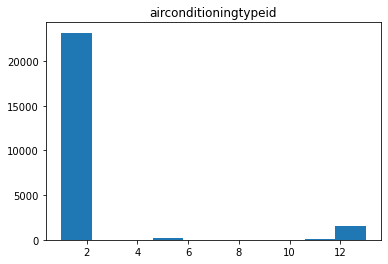

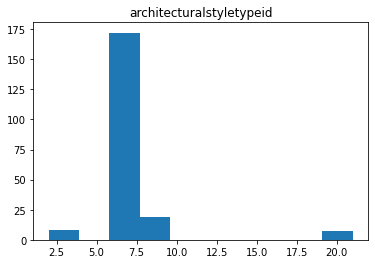

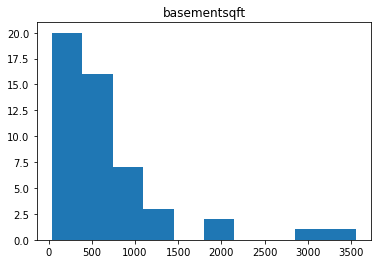

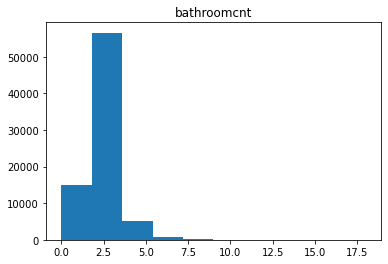

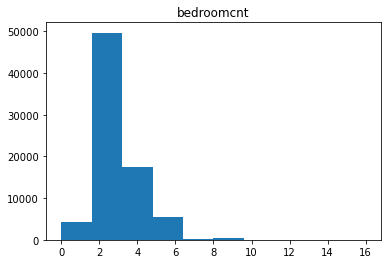

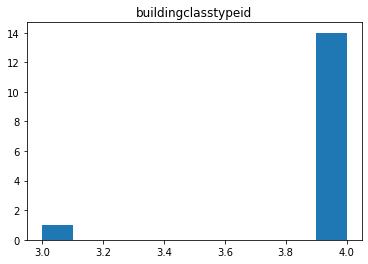

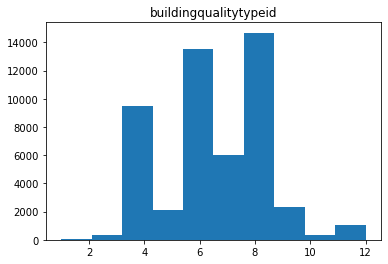

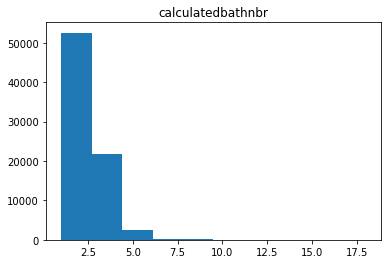

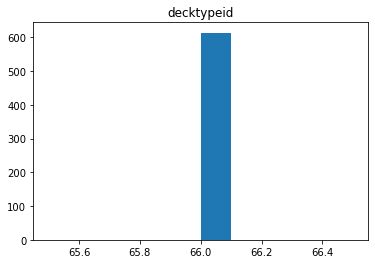

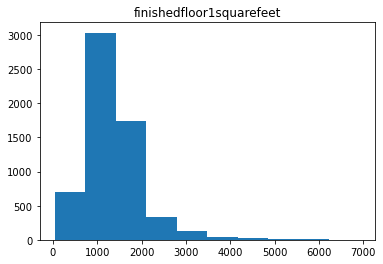

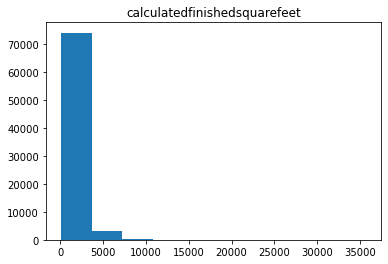

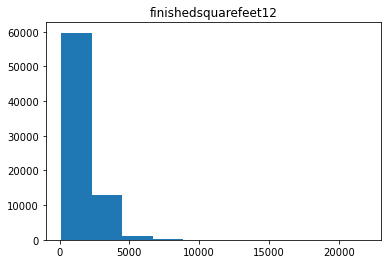

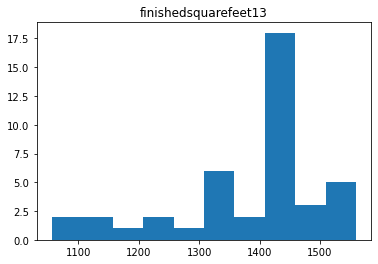

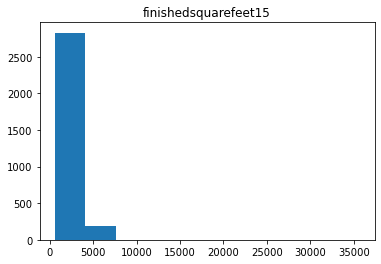

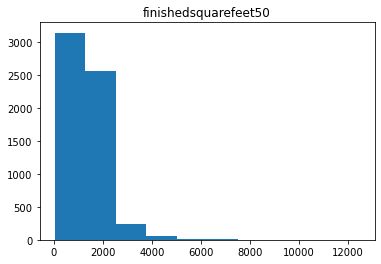

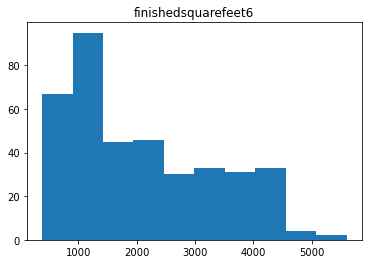

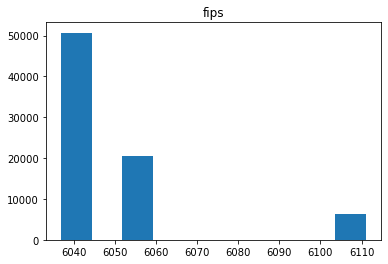

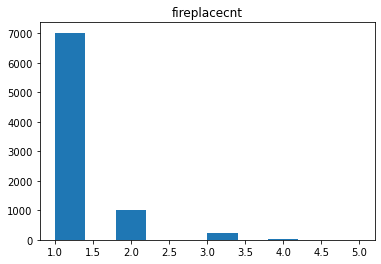

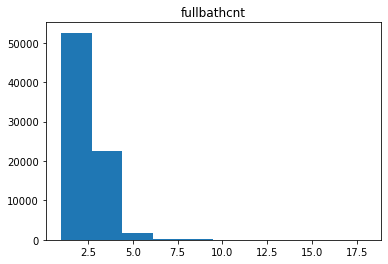

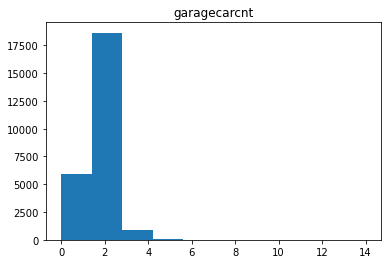

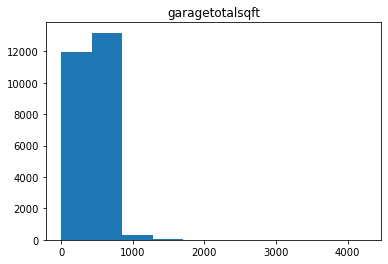

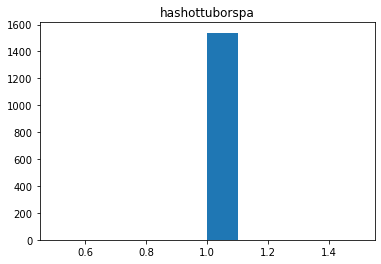

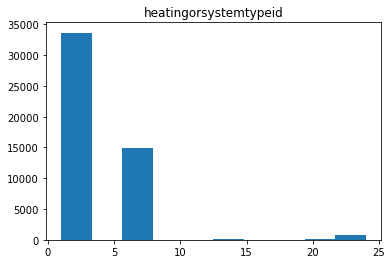

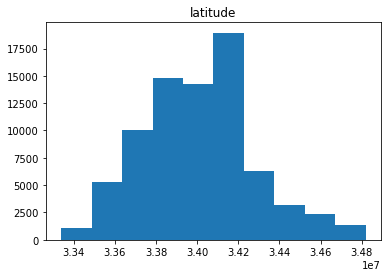

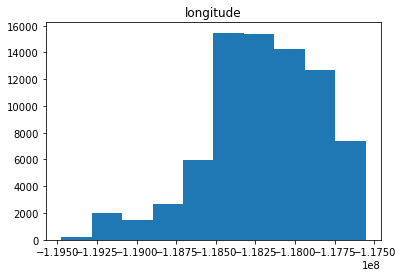

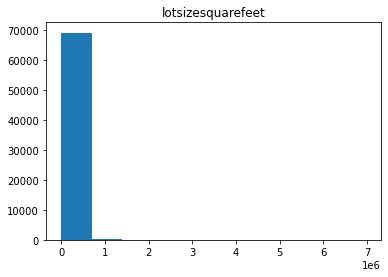

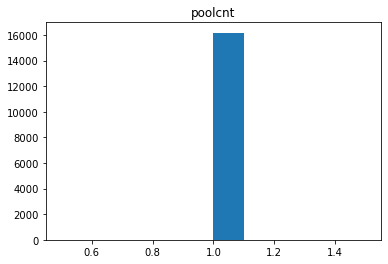

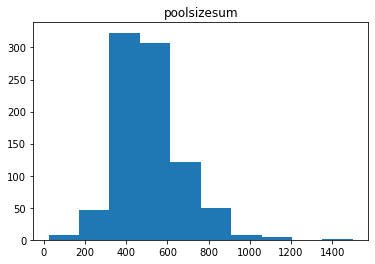

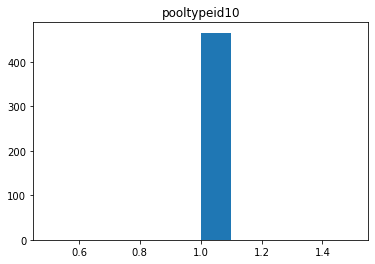

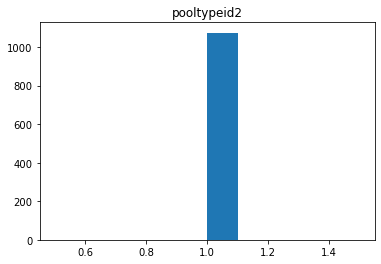

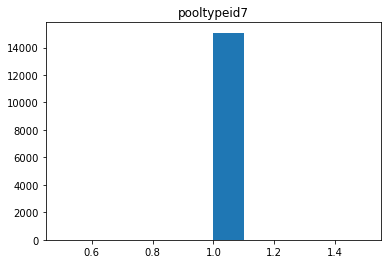

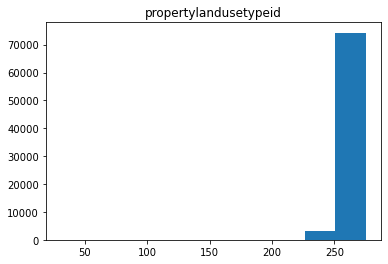

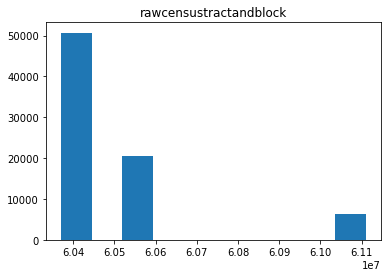

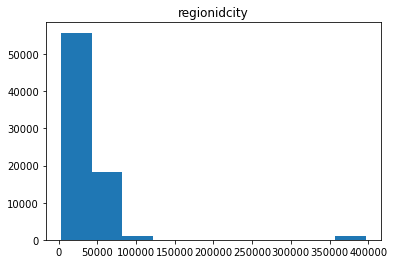

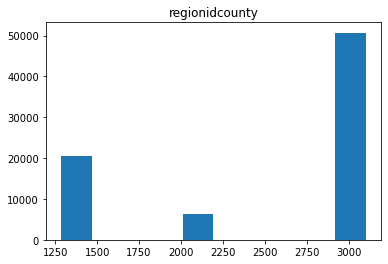

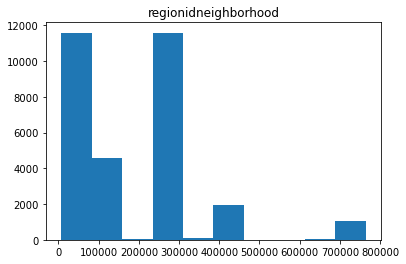

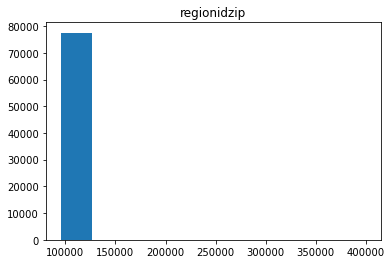

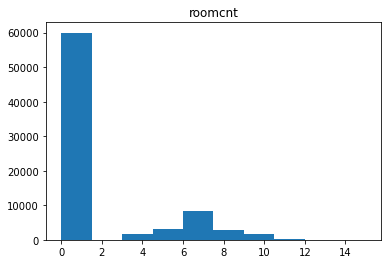

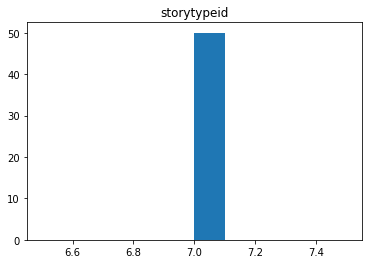

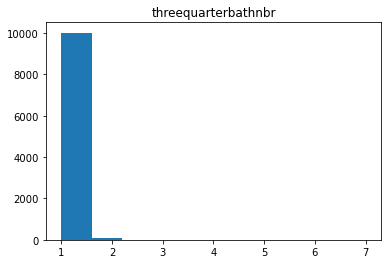

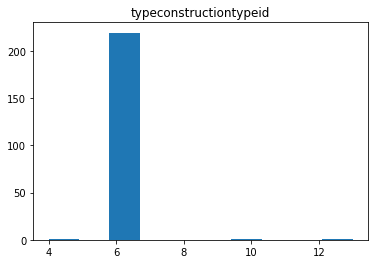

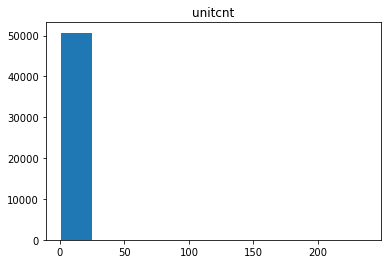

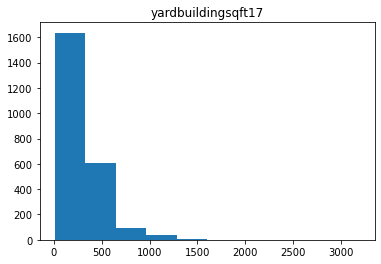

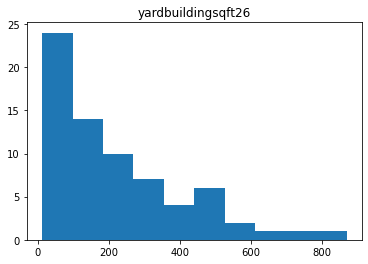

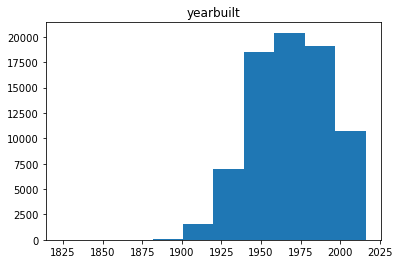

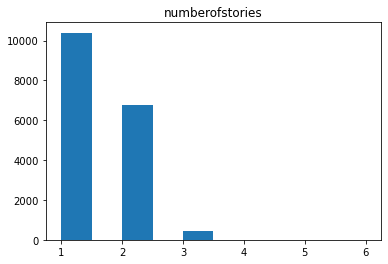

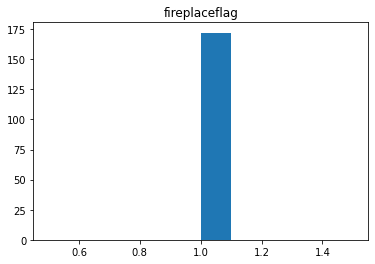

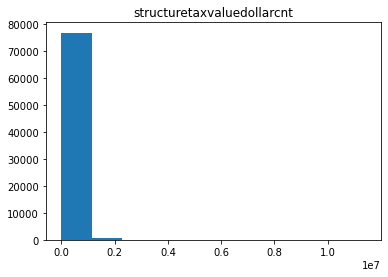

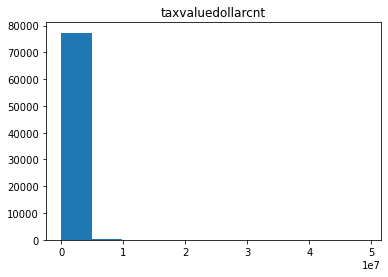

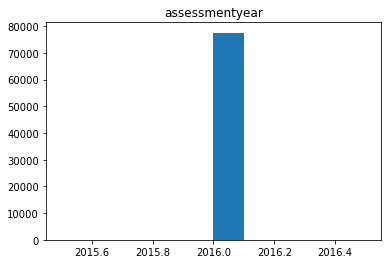

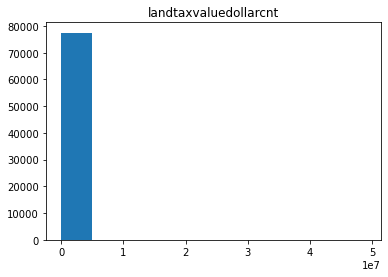

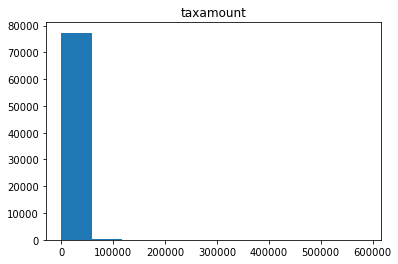

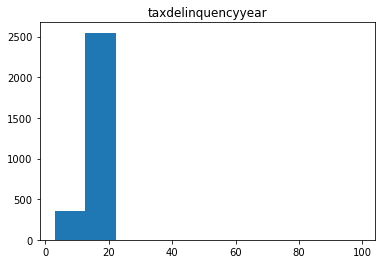

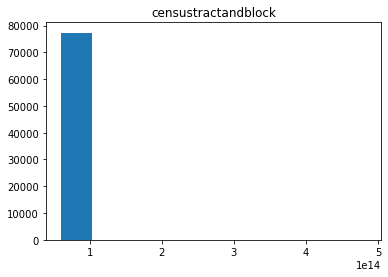

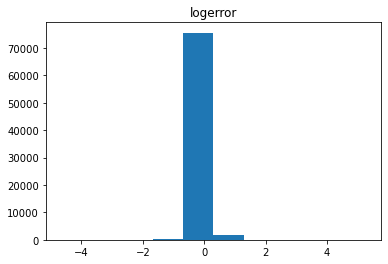

In [79]:
#distributions
for col in df.columns:
    if df[col].dtype != object and col != 'parcelid' and col != 'id':
        plt.hist(df[col])
        plt.title(col)
        plt.show()

### 3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [6]:
pd.read_clipboard()

,num_rows_missing,pct_rows_missing
parcelid,0,0.000000
airconditioningtypeid,29041,0.535486
architecturalstyletypeid,54232,0.999982


In [17]:
#breakdown step 1: get missing row values
missing_row_value = df.isnull().sum()
missing_row_value

typeconstructiontypeid    77356
storytypeid               77529
propertylandusetypeid         0
heatingorsystemtypeid     28008
buildingclasstypeid       77564
                          ...  
buildingclassdesc         77564
heatingorsystemdesc       28008
propertylandusedesc           0
storydesc                 77529
typeconstructiondesc      77356
Length: 69, dtype: int64

In [18]:
#breakdown step 2: get percentages of rows missing
percent_row_missing = round(df.isnull().sum()/len(df),2)*100
percent_row_missing

typeconstructiontypeid   100.00
storytypeid              100.00
propertylandusetypeid      0.00
heatingorsystemtypeid     36.00
buildingclasstypeid      100.00
                          ...  
buildingclassdesc        100.00
heatingorsystemdesc       36.00
propertylandusedesc        0.00
storydesc                100.00
typeconstructiondesc     100.00
Length: 69, dtype: float64

In [20]:
#finished function
def missing_values(df):
    
    # Gives value counts of missing rows
    missing_row_value = df.isnull().sum()
    
    # Gives the percentage of rows missing
    percent_row_missing = round(df.isnull().sum()/len(df),2)*100
    
    # Creates a new df for the missing rows and percent missing
    missing_df = pd.DataFrame({'num_rows_missing' : missing_row_value, 'pct_rows_missing' : percent_row_missing})
    
    return missing_df

missing_values(df)

,num_rows_missing,pct_rows_missing
typeconstructiontypeid,77356,100.00
storytypeid,77529,100.00
propertylandusetypeid,0,0.00
heatingorsystemtypeid,28008,36.00
buildingclasstypeid,77564,100.00
...,...,...
buildingclassdesc,77564,100.00
heatingorsystemdesc,28008,36.00
propertylandusedesc,0,0.00
storydesc,77529,100.00


In [21]:
#alternate
def missing_zero_values(df):
    '''
    This function takes in a dataframe and counts number of Zero values and NULL values. 
    Returns a Table with counts and percentages of each value type.
    '''
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
    columns = {0 : 'Zero Values', 1 : 'NULL Values', 2 : '% of Total NULL Values'})
    mz_table['Total Zero\'s plus NULL Values'] = mz_table['Zero Values'] + mz_table['NULL Values']
    mz_table['% Total Zero\'s plus NULL Values'] = 100 * mz_table['Total Zero\'s plus NULL Values'] / len(df)
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[
        mz_table.iloc[:,1] >= 0].sort_values(
    '% of Total NULL Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
        "There are " + str((mz_table['NULL Values'] != 0).sum()) +
          " columns that have NULL values.")
    #       mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
    return mz_table

In [23]:
missing_zero_values(df)

Your selected dataframe has 69 columns and 77579 Rows.
There are 52 columns that have NULL values.


,Zero Values,NULL Values,% of Total NULL Values,Total Zero's plus NULL Values,% Total Zero's plus NULL Values,Data Type
buildingclassdesc,0,77564,100.00,77564,100.00,object
buildingclasstypeid,0,77564,100.00,77564,100.00,float64
finishedsquarefeet13,0,77537,99.90,77537,99.90,float64
storydesc,0,77529,99.90,77529,99.90,object
basementsqft,0,77529,99.90,77529,99.90,float64
...,...,...,...,...,...,...
id,0,0,0.00,0,0.00,int64
bathroomcnt,599,0,0.00,599,0.80,float64
roomcnt,59966,0,0.00,59966,77.30,float64
propertycountylandusecode,0,0,0.00,0,0.00,object


In [80]:
#alternate from ex walkthrough
df.isnull().sum()

id                              0
parcelid                        0
airconditioningtypeid       52569
architecturalstyletypeid    77369
basementsqft                77525
                            ...  
buildingclassdesc           77560
heatingorsystemdesc         28005
propertylandusedesc             0
storydesc                   77525
typeconstructiondesc        77353
Length: 68, dtype: int64

In [81]:
df.isnull().sum()/df.shape[0]

id                         0.00
parcelid                   0.00
airconditioningtypeid      0.68
architecturalstyletypeid   1.00
basementsqft               1.00
                           ... 
buildingclassdesc          1.00
heatingorsystemdesc        0.36
propertylandusedesc        0.00
storydesc                  1.00
typeconstructiondesc       1.00
Length: 68, dtype: float64

In [82]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    pct_missing = num_missing / rows
    cols_missing = pd.DataFrame({'number_missing_rows': num_missing, 'percent_rows_missing': pct_missing})
    return cols_missing

In [83]:
nulls_by_column = nulls_by_col(df)
nulls_by_column.sort_values(by="percent_rows_missing", ascending=False).head(40)

,number_missing_rows,percent_rows_missing
buildingclassdesc,77560,1.00
buildingclasstypeid,77560,1.00
finishedsquarefeet13,77533,1.00
storytypeid,77525,1.00
basementsqft,77525,1.00
storydesc,77525,1.00
yardbuildingsqft26,77505,1.00
fireplaceflag,77403,1.00
architecturalstyletypeid,77369,1.00
architecturalstyledesc,77369,1.00


### 4. Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values.

In [4]:
pd.read_clipboard()

,num_cols_missing,pct_cols_missing,num_rows
0,23,38.333,108
1,24,40.000,123
2,25,41.667,5280


In [24]:
#alternate function (takes long)
def missing_columns(df):
    columns = df.columns.to_list()
    nulls_by_row = []
    for i in range(df.shape[0]):
        nulls_by_row.append(df.iloc[i].isna().sum())
    df['null_count'] = nulls_by_row
    df['pct_col_missing'] = df.null_count / len(columns)
    df2 = df.pct_col_missing.value_counts().rename_axis('pct_col_missing').reset_index(name='num_rows')
    df3 = df.null_count.value_counts().rename_axis('num_cols_missing').reset_index(name='num_rows').drop(columns=['num_rows'])
    df = pd.concat([df3, df2], axis = 1)
    return df

missing_columns(df).sort_values(by=['num_cols_missing'])

,num_cols_missing,pct_col_missing,num_rows
25,23,0.33,2
21,24,0.35,13
20,25,0.36,24
15,26,0.38,66
11,27,0.39,316
10,28,0.41,457
5,29,0.42,5285
8,30,0.43,3465
3,31,0.45,9911
2,32,0.46,12606


In [84]:
#breakdown from ex walkthrough
df.isnull().sum(axis=1)
#for each row, how many nulls

0        31
1        29
2        31
3        31
4        31
         ..
77570    48
77571    47
77572    48
77573    37
77574    47
Length: 77575, dtype: int64

In [85]:
#convert to df
pd.DataFrame(df.isnull().sum(axis=1))

,0
0,31
1,29
2,31
3,31
4,31
...,...
77570,48
77571,47
77572,48
77573,37


In [86]:
#once there is a df, we can specify col names
pd.DataFrame(df.isnull().sum(axis=1), columns = ['num_cols_missing']).reset_index()
#reset index to have at least 1 more col

,index,num_cols_missing
0,0,31
1,1,29
2,2,31
3,3,31
4,4,31
...,...,...
77570,77570,48
77571,77571,47
77572,77572,48
77573,77573,37


In [87]:
#groupby num cols missing .count() and reset index since previous index was lost
pd.DataFrame(df.isnull().sum(axis=1), columns = ['num_cols_missing']).reset_index().groupby('num_cols_missing').count().reset_index()

,num_cols_missing,index
0,23,2
1,24,13
2,25,24
3,26,65
4,27,316
5,28,457
6,29,5285
7,30,3465
8,31,9911
9,32,12606


In [88]:
#new index doesn't make sense, so need to rename
pd.DataFrame(df.isnull().sum(axis=1), columns = ['num_cols_missing']).reset_index().groupby('num_cols_missing').count().reset_index().rename(columns = {'index': 'num_rows' })


,num_cols_missing,num_rows
0,23,2
1,24,13
2,25,24
3,26,65
4,27,316
5,28,457
6,29,5285
7,30,3465
8,31,9911
9,32,12606


In [92]:
#finished function
def cols_missing(df):
    df2 = pd.DataFrame(df.isnull().sum(axis =1), columns = ['num_cols_missing']).reset_index()\
    .groupby('num_cols_missing').count().reset_index().\
    rename(columns = {'index': 'num_rows' })
    df2['pct_cols_missing'] = df2.num_cols_missing/df.shape[1]
    return df2

In [93]:
# sort valyes by pc_col_missing
cols_missing(df).sort_values(by = ['pct_cols_missing'], ascending = False)

,num_cols_missing,num_rows,pct_cols_missing
25,48,3,0.71
24,47,3,0.69
23,46,5,0.68
22,45,50,0.66
21,44,79,0.65
20,43,29,0.63
19,42,26,0.62
18,41,29,0.60
17,40,230,0.59
16,39,285,0.57


## Prepare

### 1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.

In [94]:
#check data shape
df.shape

(77575, 68)

In [95]:
# look at value counts for 'unitcnt'
df.unitcnt.value_counts(dropna = False)

1.00      47413
nan       26872
2.00       2031
4.00        726
3.00        529
45.00         1
6.00          1
237.00        1
42.00         1
Name: unitcnt, dtype: int64

In [96]:
# Restrict df to only properties that meet single unit criteria

single_unit = [261, 262, 263, 264, 266, 268, 273, 276, 279]
df = df[df.propertylandusetypeid.isin(single_unit)]
    
    
# Restrict df to only those properties with at least 1 bath & bed and >350 sqft area
df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & ((df.unitcnt<=1)|df.unitcnt.isnull()) & (df.calculatedfinishedsquarefeet>350)]

In [97]:
# check # of columns and rows left
df.shape

(71356, 68)

### 2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

- The input:
    - A dataframe
    - A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
    - A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
- The output:
    - The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
- hint:
    - Look up the dropna documentation.
    - You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
    - Make use of inplace, i.e. inplace=True/False.   

In [98]:
def handle_missing_values(df, prop_required_column = .5, prop_required_row = .70):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [99]:
# use the function defined above:
df = handle_missing_values(df)

In [100]:
# check shape to see how many columns and rows were dropped
df.shape

(71356, 34)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71356 entries, 0 to 77573
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            71356 non-null  int64  
 1   parcelid                      71356 non-null  int64  
 2   bathroomcnt                   71356 non-null  float64
 3   bedroomcnt                    71356 non-null  float64
 4   buildingqualitytypeid         44842 non-null  float64
 5   calculatedbathnbr             71341 non-null  float64
 6   calculatedfinishedsquarefeet  71356 non-null  float64
 7   finishedsquarefeet12          71189 non-null  float64
 8   fips                          71356 non-null  float64
 9   fullbathcnt                   71341 non-null  float64
 10  heatingorsystemtypeid         46413 non-null  float64
 11  latitude                      71356 non-null  float64
 12  longitude                     71356 non-null  float64
 13  l

In [102]:
# look at number of nulls for each column
df.isnull().sum()

id                                  0
parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           26514
calculatedbathnbr                  15
calculatedfinishedsquarefeet        0
finishedsquarefeet12              167
fips                                0
fullbathcnt                        15
heatingorsystemtypeid           24943
latitude                            0
longitude                           0
lotsizesquarefeet                8034
propertycountylandusecode           0
propertylandusetypeid               0
propertyzoningdesc              26221
rawcensustractandblock              0
regionidcity                     1322
regionidcounty                      0
regionidzip                        40
roomcnt                             0
unitcnt                         26195
yearbuilt                          35
structuretaxvaluedollarcnt         75
taxvaluedollarcnt                   1
assessmentye

### 3. Decide how to handle the remaining missing values:

- Fill with constant value.
- Impute with mean, median, mode.
- Drop row/column

In [103]:
# use your judgement to remove certain columns which you don't need

cols_to_remove = ['id',
       'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'heatingorsystemtypeid'
       ,'propertycountylandusecode', 'propertylandusetypeid','propertyzoningdesc', 
        'censustractandblock', 'propertylandusedesc']

In [104]:
def remove_columns(df, cols_to_remove):  
    df = df.drop(columns=cols_to_remove)
    return df

In [105]:
# use the function defined above to remove the columns not needed:

df = remove_columns(df, cols_to_remove)

In [106]:
# take a look at null counts again

df.isnull().sum()

parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           26514
calculatedfinishedsquarefeet        0
fips                                0
latitude                            0
longitude                           0
lotsizesquarefeet                8034
rawcensustractandblock              0
regionidcity                     1322
regionidcounty                      0
regionidzip                        40
roomcnt                             0
unitcnt                         26195
yearbuilt                          35
structuretaxvaluedollarcnt         75
taxvaluedollarcnt                   1
assessmentyear                      0
landtaxvaluedollarcnt               1
taxamount                           5
logerror                            0
transactiondate                     0
heatingorsystemdesc             24943
dtype: int64

In [107]:
# let's look at heatingorsystemdesc value counts

df.heatingorsystemdesc.value_counts(dropna = False)

Central       31357
NaN           24943
Floor/Wall    13230
Yes             850
Forced air      775
Solar           101
None             60
Radiant          23
Baseboard        13
Gravity           3
Heat Pump         1
Name: heatingorsystemdesc, dtype: int64

In [108]:
# I assume that since this is Southern CA, 'null' probably means 'None' for heating system

df.heatingorsystemdesc.fillna('None', inplace = True)

In [109]:
df.unitcnt.value_counts(dropna = False)

1.00    45161
nan     26195
Name: unitcnt, dtype: int64

In [110]:
# For unit counts, I will fill 'NaN' with unit count of 1

df.unitcnt.fillna(1, inplace = True)

In [111]:
# buildingqualitytypeid
# Overall assessment of condition of the building from 
# low number = best quality
# higher numbersw = worse quality

df.buildingqualitytypeid.value_counts(dropna = False)

nan      26514
8.00     13404
6.00     12673
4.00      8227
7.00      5505
9.00      2113
5.00      1499
11.00      846
10.00      301
3.00       149
12.00      113
1.00         9
2.00         3
Name: buildingqualitytypeid, dtype: int64

<AxesSubplot:>

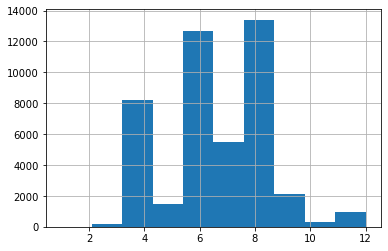

In [112]:
# look at distrubition of buildingqualitytypeid

df.buildingqualitytypeid.hist()

In [113]:
df.buildingqualitytypeid.median()

6.0

In [114]:
# fill missing values for buildingqualitytypeid with median value
df.buildingqualitytypeid.fillna(6.0, inplace = True)

In [115]:
df.isnull().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedfinishedsquarefeet       0
fips                               0
latitude                           0
longitude                          0
lotsizesquarefeet               8034
rawcensustractandblock             0
regionidcity                    1322
regionidcounty                     0
regionidzip                       40
roomcnt                            0
unitcnt                            0
yearbuilt                         35
structuretaxvaluedollarcnt        75
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          5
logerror                           0
transactiondate                    0
heatingorsystemdesc                0
dtype: int64

<AxesSubplot:>

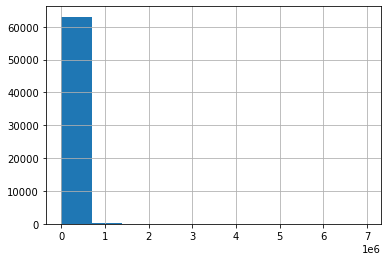

In [116]:
# look at lot-size distribution
df.lotsizesquarefeet.hist()

In [117]:
# what is the median lot size?

df.lotsizesquarefeet.median()

7313.0

In [118]:
# fill missing values with median null sizes

df.lotsizesquarefeet.fillna(7313, inplace = True)

In [119]:
df.isnull().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedfinishedsquarefeet       0
fips                               0
latitude                           0
longitude                          0
lotsizesquarefeet                  0
rawcensustractandblock             0
regionidcity                    1322
regionidcounty                     0
regionidzip                       40
roomcnt                            0
unitcnt                            0
yearbuilt                         35
structuretaxvaluedollarcnt        75
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          5
logerror                           0
transactiondate                    0
heatingorsystemdesc                0
dtype: int64

In [120]:
# I am going to drop the rest of nulls 

df.dropna(inplace = True)

In [121]:
# How many rows and columns are left?

df.shape

(69920, 24)

In [122]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,...,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc
0,10711855,2.00,3.00,8.00,2107.00,6037.00,34222559.00,-118617387.00,9158.00,60371132.32,...,1.00,1972.00,249655.00,624139.00,2016.00,374484.00,7659.36,-0.01,2017-07-07,Central
1,10711877,2.00,4.00,8.00,1882.00,6037.00,34220261.00,-118616409.00,9035.00,60371132.32,...,1.00,1972.00,253000.00,660000.00,2016.00,407000.00,8123.91,0.02,2017-08-29,Central
2,10711888,2.00,4.00,8.00,1882.00,6037.00,34222491.00,-118616854.00,9800.00,60371132.32,...,1.00,1972.00,257591.00,542923.00,2016.00,285332.00,6673.24,0.08,2017-04-04,Central
3,10711910,2.00,3.00,8.00,1477.00,6037.00,34221864.00,-118615739.00,11285.00,60371132.32,...,1.00,1960.00,57968.00,78031.00,2016.00,20063.00,1116.46,-0.04,2017-03-17,Central
4,10711923,2.00,4.00,8.00,1918.00,6037.00,34220619.00,-118615253.00,11239.00,60371132.32,...,1.00,1960.00,167869.00,415459.00,2016.00,247590.00,5239.85,-0.01,2017-03-24,Central


<AxesSubplot:ylabel='taxvaluedollarcnt'>

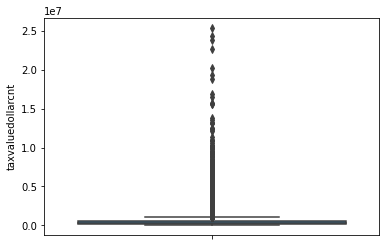

In [123]:
#check for outliers
sns.boxplot(y = 'taxvaluedollarcnt', data = df)

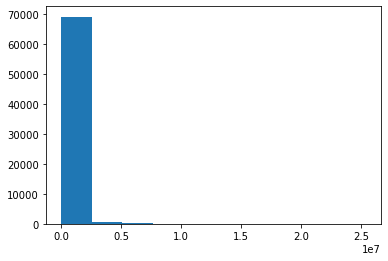

In [124]:
#Histograms for taxvalue of properties

plt.hist(df.taxvaluedollarcnt);

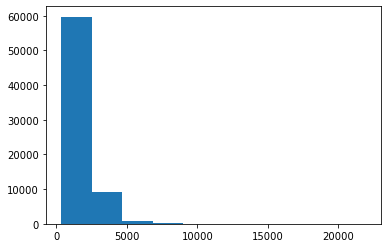

In [125]:
#Histograms for covered sq ft of properties

plt.hist(df.calculatedfinishedsquarefeet);

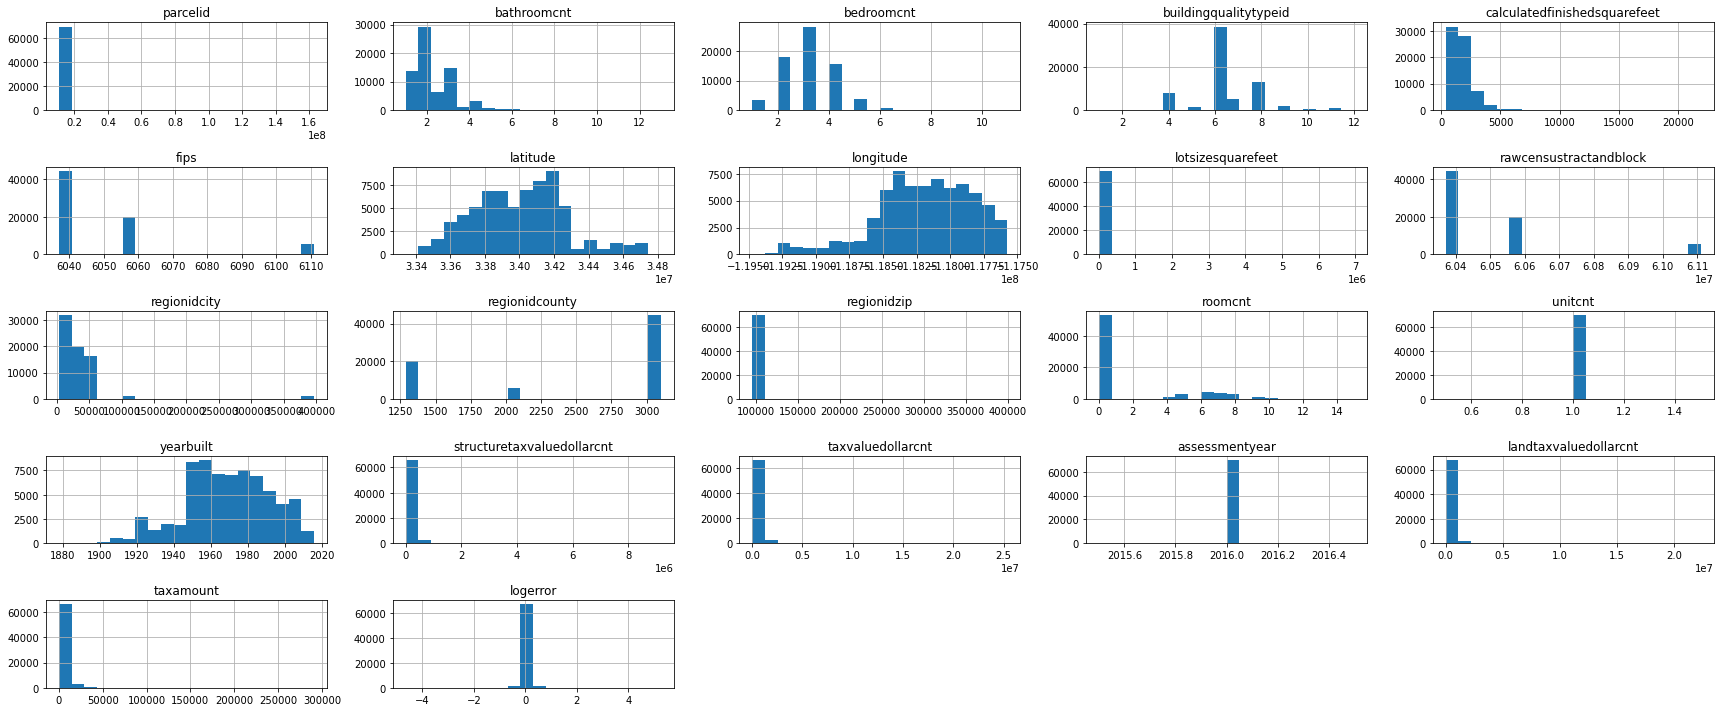

In [126]:
# look at distributions for all columns

df.hist(figsize=(24, 10), bins=20)
plt.tight_layout();

In [127]:
# Remove properties valued more than 5 million dollars

df = df[df.taxvaluedollarcnt < 5_000_000]
df.shape

(69730, 24)

In [128]:
# Remove properties valued more than 8000 square feet

df[df.calculatedfinishedsquarefeet < 8000]
df.shape

(69730, 24)

**wrangle_zillow.py**
Functions of the work above needed to acquire and prepare a new sample of data.

In [129]:
# Function to read and wrangle data:

def wrangle_zillow():
    df = pd.read_csv('zillow.csv')
    
    # Restrict df to only properties that meet single unit use criteria
    single_use = [261, 262, 263, 264, 266, 268, 273, 276, 279]
    df = df[df.propertylandusetypeid.isin(single_use)]
    
    # Restrict df to only those properties with at least 1 bath & bed and 350 sqft area
    df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & ((df.unitcnt<=1)|df.unitcnt.isnull())\
            & (df.calculatedfinishedsquarefeet>350)]

    # Handle missing values i.e. drop columns and rows based on a threshold
    df = handle_missing_values(df)
    
    # Add column for counties
    df['county'] = np.where(df.fips == 6037, 'Los_Angeles',
                           np.where(df.fips == 6059, 'Orange', 
                                   'Ventura'))    
    # drop columns not needed
    df = remove_columns(df, ['id',
       'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'heatingorsystemtypeid'
       ,'propertycountylandusecode', 'propertylandusetypeid','propertyzoningdesc', 
        'censustractandblock', 'propertylandusedesc'])


    # replace nulls in unitcnt with 1
    df.unitcnt.fillna(1, inplace = True)
    
    # assume that since this is Southern CA, null means 'None' for heating system
    df.heatingorsystemdesc.fillna('None', inplace = True)
    
    # replace nulls with median values for select columns
    df.lotsizesquarefeet.fillna(7313, inplace = True)
    df.buildingqualitytypeid.fillna(6.0, inplace = True)

    # Columns to look for outliers
    df = df[df.taxvaluedollarcnt < 5_000_000]
    df[df.calculatedfinishedsquarefeet < 8000]
    
    # Just to be sure we caught all nulls, drop them here
    df = df.dropna()
    
    return df

In [130]:
df = wrangle_zillow()
df.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,county
0,10711855,2.00,3.00,8.00,2107.00,6037.00,34222559.00,-118617387.00,9158.00,60371132.32,...,1972.00,249655.00,624139.00,2016.00,374484.00,7659.36,-0.01,2017-07-07,Central,Los_Angeles
1,10711877,2.00,4.00,8.00,1882.00,6037.00,34220261.00,-118616409.00,9035.00,60371132.32,...,1972.00,253000.00,660000.00,2016.00,407000.00,8123.91,0.02,2017-08-29,Central,Los_Angeles
2,10711888,2.00,4.00,8.00,1882.00,6037.00,34222491.00,-118616854.00,9800.00,60371132.32,...,1972.00,257591.00,542923.00,2016.00,285332.00,6673.24,0.08,2017-04-04,Central,Los_Angeles
3,10711910,2.00,3.00,8.00,1477.00,6037.00,34221864.00,-118615739.00,11285.00,60371132.32,...,1960.00,57968.00,78031.00,2016.00,20063.00,1116.46,-0.04,2017-03-17,Central,Los_Angeles
4,10711923,2.00,4.00,8.00,1918.00,6037.00,34220619.00,-118615253.00,11239.00,60371132.32,...,1960.00,167869.00,415459.00,2016.00,247590.00,5239.85,-0.01,2017-03-24,Central,Los_Angeles


In [6]:
# check if wrangle.py works as intended for zillow data:

wrangle.wrangle_zillow()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,heatingorsystemdesc,county
0,10711855,2.00,3.00,8.00,2107.00,6037.00,34222559.00,-118617387.00,9158.00,60371132.32,...,1972.00,249655.00,624139.00,2016.00,374484.00,7659.36,-0.01,2017-07-07,Central,Los_Angeles
1,10711877,2.00,4.00,8.00,1882.00,6037.00,34220261.00,-118616409.00,9035.00,60371132.32,...,1972.00,253000.00,660000.00,2016.00,407000.00,8123.91,0.02,2017-08-29,Central,Los_Angeles
2,10711888,2.00,4.00,8.00,1882.00,6037.00,34222491.00,-118616854.00,9800.00,60371132.32,...,1972.00,257591.00,542923.00,2016.00,285332.00,6673.24,0.08,2017-04-04,Central,Los_Angeles
3,10711910,2.00,3.00,8.00,1477.00,6037.00,34221864.00,-118615739.00,11285.00,60371132.32,...,1960.00,57968.00,78031.00,2016.00,20063.00,1116.46,-0.04,2017-03-17,Central,Los_Angeles
4,10711923,2.00,4.00,8.00,1918.00,6037.00,34220619.00,-118615253.00,11239.00,60371132.32,...,1960.00,167869.00,415459.00,2016.00,247590.00,5239.85,-0.01,2017-03-24,Central,Los_Angeles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77545,93577187,2.00,2.00,6.00,900.00,6111.00,34212400.00,-119027000.00,7313.00,61110056.00,...,2006.00,108211.00,309621.00,2016.00,201410.00,3280.22,0.02,2017-03-15,None,Ventura
77546,162960516,2.50,3.00,6.00,1449.00,6111.00,34273914.00,-119164501.00,6926.00,61110014.02,...,1986.00,288913.00,481521.00,2016.00,192608.00,5063.30,0.02,2017-05-08,None,Ventura
77547,162960529,4.00,4.00,6.00,2459.00,6111.00,34245590.00,-119169692.00,5400.00,61110050.04,...,2007.00,169000.00,479000.00,2016.00,310000.00,12285.88,0.01,2017-05-26,None,Ventura
77548,162960596,2.00,4.00,6.00,1379.00,6111.00,34219587.00,-119042663.00,7343.00,61110055.02,...,1960.00,224567.00,449134.00,2016.00,224567.00,4787.16,0.03,2017-07-18,None,Ventura
